In [38]:
#Libraries
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import pandas as pd
import glob
import os
import re
import pickle



In [2]:
# import prepared data
df = pd.read_csv("../data/prepared_data/basic_plus_adv_stats.csv")
df

,date,home_team,away_team,fthg,ftag,ftr,hs,as,hst,ast,...,hr,ar,xg_home,xg_away,deep_home,deep_away,ppda_home,ppda_away,xpts_home,xpts_away
0,2014-08-22,Bayern Munich,Wolfsburg,2,1,H,17,9,10,4,...,0,0,2.57,1.20,5,4,9.63,21.85,2.35,0.47
1,2014-08-23,Hoffenheim,Augsburg,2,0,H,10,12,3,2,...,0,0,1.53,0.28,6,2,6.59,5.74,2.51,0.31
2,2014-08-23,Hertha BSC,Werder Bremen,2,2,D,19,9,5,5,...,0,0,1.76,1.19,3,5,5.69,9.87,1.83,0.85
3,2014-08-23,Dortmund,Leverkusen,0,2,A,11,11,4,2,...,0,0,0.48,1.15,2,5,3.33,5.80,0.74,1.95
4,2014-08-23,1.FC Köln,Hamburger SV,0,0,D,10,19,3,4,...,0,0,0.52,0.91,4,2,13.08,7.07,0.94,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,2024-12-21,Holstein Kiel,Augsburg,5,1,H,8,17,6,4,...,0,0,2.49,1.13,10,9,13.86,7.67,2.38,0.46
3190,2024-12-21,VfB Stuttgart,St. Pauli,0,1,A,25,11,5,5,...,0,0,2.42,2.58,20,4,6.30,20.05,1.25,1.52
3191,2024-12-21,Eintracht Frankfurt,Mainz 05,1,3,A,34,9,9,3,...,0,1,2.59,0.75,11,2,5.55,19.70,2.54,0.33
3192,2024-12-22,VfL Bochum,Heidenheim,2,0,H,14,10,4,2,...,0,0,1.68,0.51,9,12,6.84,7.46,2.25,0.52


In [3]:
# Calculating the npm (number of past matches) stats for feature selection. Best results with npm = 5

# Define stats dictionary with the specified columns
stats = {
    'goals': {'scored': ('fthg', 'ftag'), 'conceded': ('ftag', 'fthg')},
    'shots': {'taken': ('hs', 'as'), 'conceded': ('as', 'hs')},
    'shots_on_target': {'taken': ('hst', 'ast'), 'conceded': ('ast', 'hst')},
    'fouls': {'fouls': ('hf', 'af'), 'fouled': ('af', 'hf')},
    'corners': {'taken': ('hc', 'ac'), 'conceded': ('ac', 'hc')},
    'yellow_cards': {'received': ('hy', 'ay'), 'provoked': ('ay', 'hy')},
    'red_cards': {'received': ('hr', 'ar'), 'provoked': ('ar', 'hr')},
    'xgoals': {'scored': ('xg_home', 'xg_away'), 'conceded': ('xg_away', 'xg_home')},
    'deep_passes': {'played': ('deep_home', 'deep_away'), 'conceded': ('deep_away', 'deep_home')},
    'ppda': {'own': ('ppda_home', 'ppda_away'), 'opponent': ('ppda_away', 'ppda_home')},
    'xpoints': {'scored': ('xpts_home', 'xpts_away'), 'conceded': ('xpts_away', 'xpts_home')}
}

# Define `npm` for the number of past matches to consider
npm = 5

# Initialize an empty list to accumulate each row's data as a dictionary
rows_list = []

# Iterate through each row to calculate rolling stats based on home and away perspectives
for index, row in df.iterrows():
    team_h = row['home_team']
    team_a = row['away_team']
    date = row['date']
    
    # Get the past `npm` games for the home team, filtered by games before the current match date
    past_matches_home = df[((df['home_team'] == team_h) | (df['away_team'] == team_h)) & (df['date'] < date)]
    past_matches_home = past_matches_home.tail(npm)

    # Get the past `npm` games for the away team, filtered by games before the current match date
    past_matches_away = df[((df['home_team'] == team_a) | (df['away_team'] == team_a)) & (df['date'] < date)]
    past_matches_away = past_matches_away.tail(npm)

    # Initialize a dictionary to store the calculated stats for each row
    row_stats = {
        'date': date,
        'home_team': team_h,
        'away_team': team_a,
        'ftr': row['ftr'],
        'fthg': row['fthg'],
        'ftag': row['ftag'],
    }
    
    # Calculate stats for the home team based on whether they played home or away in past matches
    for stat, subcategories in stats.items():
        for subcategory, columns in subcategories.items():
            home_column, away_column = columns
            # Sum the stat when the home team was actually playing at home
            stat_home_as_home = past_matches_home.loc[past_matches_home['home_team'] == team_h, home_column].sum()
            # Sum the stat when the home team was actually playing as the away team
            stat_home_as_away = past_matches_home.loc[past_matches_home['away_team'] == team_h, away_column].sum()
            row_stats[f'p_home_{stat}_{subcategory}'] = stat_home_as_home + stat_home_as_away
            
    # Calculate stats for the away team based on whether they played home or away in past matches
    for stat, subcategories in stats.items():
        for subcategory, columns in subcategories.items():
            home_column, away_column = columns
            # Sum the stat when the away team was actually playing at home
            stat_away_as_home = past_matches_away.loc[past_matches_away['home_team'] == team_a, home_column].sum()
            # Sum the stat when the away team was actually playing as the away team
            stat_away_as_away = past_matches_away.loc[past_matches_away['away_team'] == team_a, away_column].sum()
            row_stats[f'p_away_{stat}_{subcategory}'] = stat_away_as_home + stat_away_as_away

    # Calculate points for the home team in the past `npm` games
    points_home = (
        (past_matches_home.loc[past_matches_home['home_team'] == team_h, 'ftr'] == 'H').sum() * 3 +
        (past_matches_home.loc[past_matches_home['away_team'] == team_h, 'ftr'] == 'A').sum() * 3 +
        (past_matches_home['ftr'] == 'D').sum() * 1
    )
    row_stats[f'p_home_points'] = points_home
    
    # Calculate points for the away team in the past `npm` games
    points_away = (
        (past_matches_away.loc[past_matches_away['home_team'] == team_a, 'ftr'] == 'H').sum() * 3 +
        (past_matches_away.loc[past_matches_away['away_team'] == team_a, 'ftr'] == 'A').sum() * 3 +
        (past_matches_away['ftr'] == 'D').sum() * 1
    )
    row_stats[f'p_away_points'] = points_away
    
    # Append the dictionary for this row to the list
    rows_list.append(row_stats)

# Convert the list of dictionaries to a DataFrame
rolling_stats = pd.DataFrame(rows_list)

# Display the final DataFrame with only the desired columns
rolling_stats

,date,home_team,away_team,ftr,fthg,ftag,p_home_goals_scored,p_home_goals_conceded,p_home_shots_taken,p_home_shots_conceded,...,p_away_xgoals_scored,p_away_xgoals_conceded,p_away_deep_passes_played,p_away_deep_passes_conceded,p_away_ppda_own,p_away_ppda_opponent,p_away_xpoints_scored,p_away_xpoints_conceded,p_home_points,p_away_points
0,2014-08-22,Bayern Munich,Wolfsburg,H,2,1,0,0,0,0,...,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0,0
1,2014-08-23,Hoffenheim,Augsburg,H,2,0,0,0,0,0,...,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0,0
2,2014-08-23,Hertha BSC,Werder Bremen,D,2,2,0,0,0,0,...,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0,0
3,2014-08-23,Dortmund,Leverkusen,A,0,2,0,0,0,0,...,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0,0
4,2014-08-23,1.FC Köln,Hamburger SV,D,0,0,0,0,0,0,...,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,2024-12-21,Holstein Kiel,Augsburg,H,5,1,3,11,58,75,...,4.89,7.25,23,48,122.15,43.11,6.46,7.46,3,5
3190,2024-12-21,VfB Stuttgart,St. Pauli,A,0,1,12,8,72,60,...,5.05,7.13,17,42,100.14,69.83,5.57,8.33,10,3
3191,2024-12-21,Eintracht Frankfurt,Mainz 05,A,1,3,11,6,69,65,...,12.62,4.49,45,24,47.06,74.13,12.37,1.88,10,12
3192,2024-12-22,VfL Bochum,Heidenheim,H,2,0,2,6,56,73,...,6.49,13.32,18,54,131.70,49.49,3.34,10.96,2,0


In [4]:
# Labelling of the categorical target variable Fulltime Result (FTR)
rolling_stats["ftr_num"] = rolling_stats["ftr"].apply(lambda x: 1 if x == "D" else (2 if x == "H" else 3))

In [5]:
## introduce temporal feature as days since first match in summer 2014:
rolling_stats['date'] = pd.to_datetime(rolling_stats['date'])
first_match_date = rolling_stats['date'].min()

# Days since first match
rolling_stats['days_since_start'] = (rolling_stats['date'] - first_match_date).dt.days
rolling_stats

,date,home_team,away_team,ftr,fthg,ftag,p_home_goals_scored,p_home_goals_conceded,p_home_shots_taken,p_home_shots_conceded,...,p_away_deep_passes_played,p_away_deep_passes_conceded,p_away_ppda_own,p_away_ppda_opponent,p_away_xpoints_scored,p_away_xpoints_conceded,p_home_points,p_away_points,ftr_num,days_since_start
0,2014-08-22,Bayern Munich,Wolfsburg,H,2,1,0,0,0,0,...,0,0,0.00,0.00,0.00,0.00,0,0,2,0
1,2014-08-23,Hoffenheim,Augsburg,H,2,0,0,0,0,0,...,0,0,0.00,0.00,0.00,0.00,0,0,2,1
2,2014-08-23,Hertha BSC,Werder Bremen,D,2,2,0,0,0,0,...,0,0,0.00,0.00,0.00,0.00,0,0,1,1
3,2014-08-23,Dortmund,Leverkusen,A,0,2,0,0,0,0,...,0,0,0.00,0.00,0.00,0.00,0,0,3,1
4,2014-08-23,1.FC Köln,Hamburger SV,D,0,0,0,0,0,0,...,0,0,0.00,0.00,0.00,0.00,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,2024-12-21,Holstein Kiel,Augsburg,H,5,1,3,11,58,75,...,23,48,122.15,43.11,6.46,7.46,3,5,2,3774
3190,2024-12-21,VfB Stuttgart,St. Pauli,A,0,1,12,8,72,60,...,17,42,100.14,69.83,5.57,8.33,10,3,3,3774
3191,2024-12-21,Eintracht Frankfurt,Mainz 05,A,1,3,11,6,69,65,...,45,24,47.06,74.13,12.37,1.88,10,12,3,3774
3192,2024-12-22,VfL Bochum,Heidenheim,H,2,0,2,6,56,73,...,18,54,131.70,49.49,3.34,10.96,2,0,2,3775


In [8]:
## add team-identifier with label encoding ordered by team performance since 2014
teams_ordered = [
    "Bayern Munich", "Dortmund", "Leverkusen", "Leipzig", "M'gladbach",
    "Wolfsburg", "Eintracht Frankfurt", "Hoffenheim", "Mainz 05", "Freiburg",
    "Augsburg", "Werder Bremen", "Hertha BSC", "VfB Stuttgart", "1.FC Köln",
    "Schalke 04", "Union Berlin", "Hamburger SV", "Hannover 96", "VfL Bochum",
    "Darmstadt", "Fortuna Düsseldorf", "Ingolstadt", "Arminia Bielefeld", "Heidenheim",
    "Paderborn", "1.FC Nürnberg", "Greuther Fürth", "St. Pauli", "Holstein Kiel"
]

# Create a mapping for label encoding based on the order of teams
team_label_map = {team: idx for idx, team in enumerate(teams_ordered)}

# Apply label encoding to home and away teams
rolling_stats['home_team_id'] = rolling_stats['home_team'].map(team_label_map)
rolling_stats['away_team_id'] = rolling_stats['away_team'].map(team_label_map)

# Verify the result
rolling_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             3194 non-null   datetime64[ns]
 1   home_team                        3194 non-null   object        
 2   away_team                        3194 non-null   object        
 3   ftr                              3194 non-null   object        
 4   fthg                             3194 non-null   int64         
 5   ftag                             3194 non-null   int64         
 6   p_home_goals_scored              3194 non-null   int64         
 7   p_home_goals_conceded            3194 non-null   int64         
 8   p_home_shots_taken               3194 non-null   int64         
 9   p_home_shots_conceded            3194 non-null   int64         
 10  p_home_shots_on_target_taken     3194 non-null   int64      

In [30]:
# Select features and target
features_cl = rolling_stats.select_dtypes("number").drop(columns=["fthg", "ftag", "ftr_num"])
target_cl = rolling_stats["ftr_num"]

# Split data into train and test sets
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(features_cl, target_cl, test_size=0.2, random_state=42)

In [48]:
# Define pipeline: SMOTE + Random Forest to ensure SMOTE is only applied during the training
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE during training
    ('rf', RandomForestClassifier(random_state=42))  # Random Forest model
])

# run Hyperparameter Tuning:
# Hyperparameter grid for Random Forest
#initial param grid
#param_grid = {
#    'rf__n_estimators': [100, 200, 300],
#    'rf__max_depth': [10, 20, 30, None],
#    'rf__min_samples_split': [2, 5, 10],
#    'rf__min_samples_leaf': [1, 2, 4],
#    'rf__class_weight': ['balanced', 'balanced_subsample']}
#finetuning grid
param_grid = {
    'rf__n_estimators': [150, 175, 200, 225, 250],
    'rf__max_depth': [18, 20, 22, 25, None],
    'rf__min_samples_split': [8, 10, 11, 13],
    'rf__min_samples_leaf': [1, 3],
    'rf__class_weight': ['balanced', 'balanced_subsample']
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_cl, y_train_cl)

# Print the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Parameters: {'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 25, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 13, 'rf__n_estimators': 225}


In [44]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_cl)

# Evaluate performance
print(f"Test Accuracy: {accuracy_score(y_test_cl, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cl, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cl, y_pred))

## further evaluation:
from sklearn.metrics import cohen_kappa_score, balanced_accuracy_score

# Predictions and ground truth
y_true = y_test_cl

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Test Accuracy: 0.4460

Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.25      0.26       162
           2       0.54      0.54      0.54       282
           3       0.43      0.47      0.45       195

    accuracy                           0.45       639
   macro avg       0.42      0.42      0.42       639
weighted avg       0.44      0.45      0.44       639


Confusion Matrix:
[[ 40  66  56]
 [ 63 153  66]
 [ 39  64  92]]
Cohen's Kappa: 0.1424
Balanced Accuracy: 0.4204


In [ ]:
## log reg model

# Define pipeline: SMOTE + PCA + Logistic Regression
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA()),
    ('log_reg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100))
])

# Define hyperparameter grid for tuning
param_grid = {
    'pca__n_components': [5, 10, 15, 20],  # Adjust based on dataset
    'log_reg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'log_reg__penalty': ['l2']  # Optional if considering other penalties
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_cl, y_train_cl)

# Print best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_cl)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, balanced_accuracy_score

print(f"Test Accuracy: {accuracy_score(y_test_cl, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cl, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_cl, y_pred))
print(f"Cohen's Kappa: {cohen_kappa_score(y_test_cl, y_pred):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_cl, y_pred):.4f}")


In [91]:
# Save the scaler and PCA to transform new data in Streamlit
import pickle

with open("../pickle_files/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("../pickle_files/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

# Save the logistic regression model for Streamlit
with open('../pickle_files/log_reg_model.pkl', 'wb') as file:
    pickle.dump(log_reg, file)

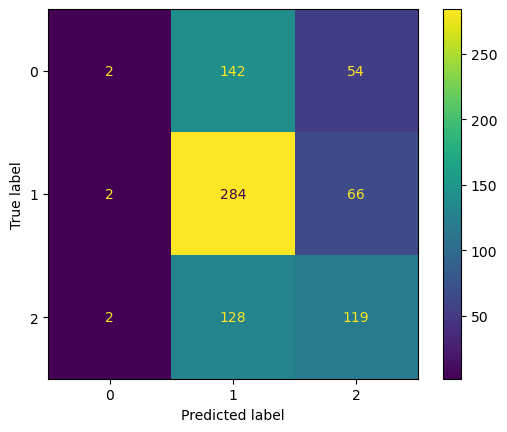

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_cl, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig("confusion_matrix.png", format="png", dpi=300)
plt.show()